In [ ]:
### Colab ###
# Install system dependencies
!apt update
!apt install -y gfortran libopenblas-dev liblapack-dev libffi-dev libmpc-dev \
    libgmp-dev libblas-dev libatlas-base-dev build-essential python3-dev \
    libeigen3-dev libmumps-seq-dev

# Install dependencies with pip
!pip install cython numpy scipy tinyarray matplotlib

# Install Kwant from source
!pip install git+https://gitlab.kwant-project.org/kwant/kwant.git

# QH en grafeno

In [2]:
## Importamos los módulos básicos:

import kwant  #importamos kwant
import kwant.continuum  #para los modelos continuos
import matplotlib.pyplot as plt  #pyplot para los plots
import numpy as np  #numpy para trabajar con vectores
import scipy as sp  #scipy para diagonalizaciones, integraciones, etc
import sympy  # importamos sympy para que las matrices se muestren mejor en el notebook

sympy.init_printing()

import tinyarray

# Definimos las matrices de Pauli:
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

## Landauer-Buttiker formula
Por ahora hemos empleado sólo la fórmuala de Landauer, en este tutorial en cambio usaremos múltiples terminales:

$$I_p = \frac{e^2}{h}\sum_q T_{pq} (E_F) (V_p-V_q)$$

En particular, para los sistemas con geometrias tipo barra Hall emplearemos la ecuación anterior para resolver $R_{xx}$ y $R_{xy}$ teniendo en cuenta que la resistencia se relaciona con la caída de potencial y la corriente como:

$$R_{ij;kl} = (V_i − V_j )/(I_k − I_l ).$$

Estamos por lo tanto resolviendo el problema inverso a la fórmula de Landauer-Buttiker. Dada una corriente obtenemos los $V_i$,
Para ello empleamos el siguiente código


##  <span style="color:orange">Ejercicio 1: </span>
Prueba este código escibiendo a mano una matriz de conductancias para una barra hall de 6 terminales con un único estado de borde quiral.
Qué se obtiene para $R_xx$, $R_{xy}$?

In [3]:

def solve_multiTerminal(Tmatrix, lead0=0, I0=[0, 0, 0, 0, -1, 1], num_leads=6):
    G = Tmatrix
    G -= np.diag(np.sum(G, axis=0))

    temp = list(range(0, num_leads))
    temp.remove(lead0)

    G = G[temp, :]
    G = G[:, temp]

    # invert R = G^-1
    try:
        r = np.linalg.inv(G);
        # Solve V = R I
        V = r @ np.array([I0[i] for i in temp])
        Vout = list(V[0:lead0]) + list([0]) + list(V[lead0:])
    except np.linalg.LinAlgError:
        Vout = [i * 0 for i in range(num_leads)]
    return Vout


In [4]:
### >> Pruebas para el solucionador de V


## QH en grafeno en tight-binding

Ahora construiremos un sistema con geometría tipo Hall en grafeno, incluir el campo magnético en un tight-binding requiere de un poco de cuidado.

Dado un tight-binding con base $\ket{n, \alpha}$, donde $n$ indica el índice espacial y  $\alpha$ es un número cuántico orbital,

\begin{equation}
    H = \sum_n \epsilon_{n,\alpha} \ketbra{n, \alpha}{n, \alpha} -
            \sum_{n,m} t_{\alpha, \beta} (\vec{n-m}) \ketbra{n, \alpha}{m, \beta}~,
\end{equation}

La sustitución mínima es $\vec{p} \to \vec{p} + e\vec{A} $ donde $\vec{A}$ es el vector potencial: $\vec{B} (\vec{r})= \nabla \times \vec{A}(\vec{r})$.

El vector potencial se introduce con la siguiente transformación unitaria:

\begin{align}
    e^{-i\phi} H(\vec{r},\vec{p}) e^{i\phi} & = H\left[\vec{r},\vec{p}+{e}\vec{A}(\vec{r})\right]~,\\
   \phi(\vec{r}) & = \frac{e}{\hbar} \int_{\vec{r}} \vec{A}(\vec{s}) \cdot d\vec{s}~,
\end{align}

donde la integral es sobre una línea dada por $\vec{r}$.

El Hamiltoniano se modifica como:

\begin{multline}
    \braket{n, \alpha|H \left[\vec{r},\vec{p}+e\vec{A}(\vec{r})\right]}{m, \beta}  =
    \exp\left[ -\frac{ie}{\hbar} \int^{\vec{R_{n, \alpha}}}_{\vec{R_{m, \beta}}} \vec{A}(\vec{s}) \cdot d\vec{s}\right]
    \braket{n, \alpha|H }{m, \beta}~,
\end{multline}

donde $\vec{R_{n, \alpha}}$ es el vector de posición del sitio $n$.
La opción más sencilla para la integral de línea es una línea recta entre dos sitios de un tight-binding. De este modo, si consideramos que podemos promediar el potencial vector entre esos dos sitios, la integral de puede aproximar por el área:

\begin{align}
    \frac{e}{\hbar} \int^{\vec{R_{n, \alpha}}}_{\vec{R_{m, \beta}}} \vec{A}(\vec{s}) \cdot d\vec{s}  & \simeq
    \phi(\vec{R_{n, \alpha}}, \vec{R_{m, \beta}}) ~,\\
    \phi(\vec{R_{n, \alpha}}, \vec{R_{m, \beta}}) & \equiv \frac{e}{\hbar} (\vec{R_{m, \beta}-\vec{R_{n, \alpha}}})\frac{\vec{A}(\vec{R_{n, \alpha}}) + \vec{A}(\vec{R_{m, \beta}})}{2} ~.
\end{align}

El hopping queda entonces modificado por:
    \begin{equation}
    t_{\alpha, \beta} (\vec{n-m}) = e^{-i\phi(\vec{R_{n, \alpha}}, \vec{R_{m, \beta}})}t^0_{\alpha, \beta} (\vec{n-m})~,
    \end{equation}
    where the $t^0_{\alpha, \beta} (\vec{n-m})$ is the hopping amplitude in the absence of external fields.

Para un campo magnético en la dirección $z$, en el gauge de Laundau:
\begin{align}
    \vec{A}_1 & = (-B y, 0, 0)~, \\
    \vec{A}_2 & = (0, B x, 0)~,
\end{align}

Eligiendo la primera opción:
\begin{equation}
    \phi(\vec{R_{n}}, \vec{R_{m}}) =
    \frac{\lambda_B (y_n+y_m)}{2} (x_n-x_m)~,
\end{equation}

donde $\lambda_B \propto B$.



----------------------------
Recordatorio de los pasos de creación de un código básico en Kwant:

    1. Crear un sistema de enlace fuerte “vacío”.
    2. Establecer sus elementos de matriz (onsite) y acoplamientos (*hoppings*).> Esto lo haremos con el discretizado de un modelo CONTINUO
    3. Conectar los contactos *leads* (sistemas de enlace fuerte con simetría traslacional).
    4. Pasar el sistema finalizado a un solucionador (*solver*).
---------------------------

In [64]:
def qhe_hall_bar_graphene(W=10, w_lead=10, spacing_leads=[10, 60, 10], add_cells = 0):

    # 1) inicializamos un Builder y definimos una red
    sqrt3 = 1/np.sqrt(3)
    lat = kwant.lattice.honeycomb(1., norbs=1)
    subA, subB = lat.sublattices
    L = np.sum(spacing_leads) + w_lead * (len(spacing_leads) - 1)
    sys = kwant.Builder()

    # 2) rellenamos el sistema con sitios de la red

    def bar(pos):
        (x, y) = pos
        return (0 <= x <= L and 0 <= y <= W)

    # Onsite and hoppings
    def onsite(site, mu):
        return -mu

    def hopping_Ax(site1, site2, t, B):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return -t * np.exp(-0.5j * B * (x1 + x2) * (y1 - y2))


    def make_lead_hop_y(x0):
        def hopping_Ay(site1, site2, t, B):
            x1, y1 = site1.pos
            x2, y2 = site2.pos
            return -t * np.exp(-1j * B * x0 * (y1 - y2))

        return hopping_Ay

    def lead_hop_vert(site1, site2, t):
        return -t

    lead_onsite = lambda site, mu_lead: - mu_lead

    sys[lat.shape(bar, (0, 0))] = onsite
    sys[lat.neighbors()] = hopping_Ax
    sys.eradicate_dangling()


    # 3) Creamos el lead de contacto:
    sym_lead_vertical = kwant.TranslationalSymmetry(lat.vec((-1, 2)))
    w_vert_lead = W
    for i in range(len(spacing_leads) - 1):
        lead_vertical = kwant.Builder(sym_lead_vertical)

        Li = sum(spacing_leads[:i + 1]) + i * w_vert_lead

        def lead_shape_vertical(pos):
            (x, y) = pos
            return 0 <= x - Li <= w_vert_lead
        if add_cells >0:
            def sys_shape_vertical(pos):
                (x, y) = pos
                return 0 <= x - Li <= w_vert_lead and (-add_cells <= y <= W + add_cells)
            sys[lat.shape(sys_shape_vertical, (Li, 0))] = onsite
            sys[lat.neighbors()] = hopping_Ax
        lead_vertical[lat.shape(lead_shape_vertical, (+Li, W))] = lead_onsite
        lead_vertical[lat.neighbors()] = lead_hop_vert
        sys.attach_lead(lead_vertical)
        sys.attach_lead(lead_vertical.reversed())

    #3b) Leads: Horizontal: they are numbered as 4 and 5!!
    sym_lead = kwant.TranslationalSymmetry(lat.vec((-1, 0)))
    sym_lead.add_site_family(subA, other_vectors=[
        (-1, 2)])  # other vectors es en función de la base! Este vector es [0, sqrt(3)]
    sym_lead.add_site_family(subB, other_vectors=[(-1, 2)])

    lead = kwant.Builder(sym_lead)

    def lead_shape(pos):
        (x, y) = pos
        return 0 < y <= w_lead

    lead[lat.shape(lead_shape, (-1, 0))] = lead_onsite
    lead[lat.neighbors()] = make_lead_hop_y(0)

    sys.attach_lead(lead)

    sym_lead = kwant.TranslationalSymmetry(lat.vec((+1, 0)))
    sym_lead.add_site_family(subA, other_vectors=[
        (-1, 2)])  # other vectors es en función de la base! Este vector es [0, sqrt(3)]
    sym_lead.add_site_family(subB, other_vectors=[(-1, 2)])
    lead = kwant.Builder(sym_lead)
    lead[lat.shape(lead_shape, (L, 0))] = lead_onsite
    lead[lat.neighbors()] = make_lead_hop_y(L)

    sys.attach_lead(lead)

    return sys



In [65]:
### >>> Desglose de los comandos en clase

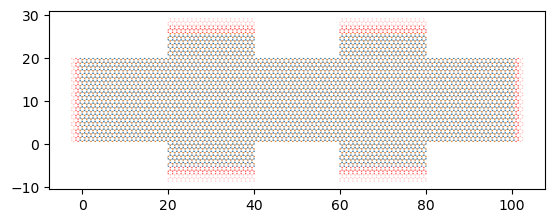

In [66]:
W=20;  spacing_leads=[20, 20, 20];
syst = qhe_hall_bar_graphene(W=W, w_lead=W, spacing_leads=spacing_leads, add_cells=5).finalized()
kwant.plot(syst);

In [68]:
## Calculemos la conductancia en función del campo magnético:

Bs = np.linspace(0, 0.25, 50)
num_leads = len(syst.leads)
en = 0.

p = dict(t=1.0, mu=0.5, mu_lead=0.5)
systp = syst.precalculate(energy=en, leads=np.arange(num_leads - 2), params=p, )

VHall = np.empty((len(Bs), num_leads))
Tlist = np.empty((len(Bs), num_leads, num_leads))
for i, B in enumerate(Bs):
    p.update(B=B)
    smatrix = kwant.smatrix(systp, energy=en, params=p)
    Tmatrix = [[smatrix.transmission(i, j) for i in range(num_leads)] for j in range(num_leads)]
    Tlist[i] = Tmatrix
    VHall[i] = (solve_multiTerminal(Tmatrix, lead0=2, I0=[0, 0, 0, 0, 1, -1], num_leads=6))

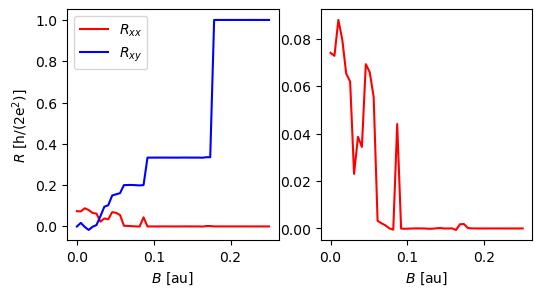

In [69]:
fig, axs = plt.subplots(1,2,figsize=(6,3))

Rxy = (VHall[ :, 2] - VHall[:, 3])
Rxx = (VHall[ :, 2] - VHall[:, 0])

axs[0].plot(Bs, Rxx, ls='-', c='r', label=r'$R_{xx}$')
axs[0].plot(Bs, Rxy, ls='-', c='b', label=r'$R_{xy}$')
axs[1].plot(Bs, Rxx, ls='-', c='r', label=r'$R_{xx}$')
axs[0].set(xlabel=r'$B~\mathrm{[au]}$', ylabel=('$R \mathrm{~[h/(2e^2)]}$'))
axs[1].set(xlabel=r'$B~\mathrm{[au]}$')
axs[0].legend()


##  <span style="color:orange">Ejercicio 2: </span>
Modifica la función onsite para incluir unas impurezas aleatorias, con probabilidad $p$ y energía de sitio $E_{dis}$.
Por ejemplo, puedes extraer un número aleatorio $q$ entre 0 y 1 y modificar la energía a un valor $E_{dis}$ si $q<p$. Siendo $p$ una probabilidad.
Puedes emplear la función `np.random.rand`

Puedes emplear por ejemplo como valores iniciales $p=0.01, 0.02, 0.05$ y $E_{dis}=1. $

- Calcula la conductancia
- Aumenta la densidad $p$ y/o la energía de las impurezas. Cómo se ven afectados los plateaus?

In [70]:
## Solución:
#modifica la onsite por:
def onsite(site, mu, Edis, prob):
    randp = np.random.rand()
    if randp < prob:
        return - mu + Edis
    else:
        return -mu

# Ahora hay nuevos parámetros, entonces, un diccionario podría ser, por ejemplo:
p = dict(t=1.0, mu=0.5, mu_lead=0.5, Edis = 1, prob = 0.05)

##  <span style="color:orange">Ejercicio 3: (más conceptual) </span>
Representa las resistencias calculadas entre otras parejas de contactos. Obtienes el mismo resultado que en el ejercicio 1?
Al añadir desorden, cómo cambia esto?
Si haces un sistema más largo (y con un espaciado entre leads distinto), ves alguna diferencia en las resistencias longitudinales y transversales para las parejas de leads más alejadas?

##  <span style="color:orange">Ejercicio 4: </span>
Modifica la función `obtain_wf` que hemos empleado anteriormente (la incluyo debajo) para incluir, en el primer panel las resistencias $R_{xx} y $R_{xy}$ en vez de la relación de dispersión de los leads.
Busca puntos interesantes como:
- Transiciones entre plateaus,
- Situaciones con mucho desorden
- Investiga también como cambia la función de onda de scattering cambiando el lead de inyección `lead_in`

In [54]:

def obtain_wf(syst, energy, params, lead_in = 4):
    # Calculamos la función de onda del lead 0 a la energía dada
    psi = kwant.wave_function(syst, energy=energy, params =  params)(lead_in)
    # Definimos el operador corriente y densidad del systema
    rho = kwant.operator.Density(syst)
    J = kwant.operator.Current(syst)
    # Calculamos la corriente de todos los modos entrantes
    current = sum((J(p, params = params) for p in psi))
    density = sum((rho(p) for p in psi))
    # Inicializamos la figura
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(131);
    ax2 = fig.add_subplot(132);
    ax3 = fig.add_subplot(133);
    # Obtenemos las bandas:
    bands = kwant.physics.Bands(syst.leads[0], params = params)
    momenta = np.linspace(-np.pi, np.pi, 101)
    energies = [bands(k) for k in momenta]

    ax1.plot(momenta, energies, c='grey')
    ax1.axhline(y=energy, color='r', ls='--')
    ax1.set_title('Relación de dispersión del lead')

    # Obtenemos la densidad:
    ax2.set_title('Densidad de la func de onda de scat')
    kwant.plotter.map(syst, density, ax=ax2, vmax=0.8);

    # Obtenemos la corriente:
    ax3.set_title('Corriente')
    kwant.plotter.current(syst, current, ax=ax3, cmap='Blues');

    ax1.set_xlabel('k');
    ax1.set_ylabel('Energy')
    ax2.set_xlabel('x');
    ax2.set_ylabel('y');
    ax3.set_xlabel('x');
    ax3.set_ylabel('y');

    # Creamos unos plots ficticios para obtener fácilmente las colorbars
    fig2 = plt.figure(figsize=(2, 2));
    cmap2 = plt.imshow(np.array([[max(density), min(density)]]), cmap="Oranges")
    maxcur = np.max(kwant.plotter.interpolate_current(syst, current, )[0])
    cmap3 = plt.imshow(np.array([[maxcur, 0]]), cmap="Blues")
    fig2.set_visible(False);
    fig.colorbar(cmap2, ax=ax2, shrink=0.6)
    fig.colorbar(cmap3, ax=ax3, shrink=0.6)
    [ax.set(facecolor=('gainsboro')) for ax in [ax2, ax3]]
    # [kwant.plot(syst, ax=ax, site_lw=0., site_color='grey') for ax in [ax2, ax3]]
    return fig


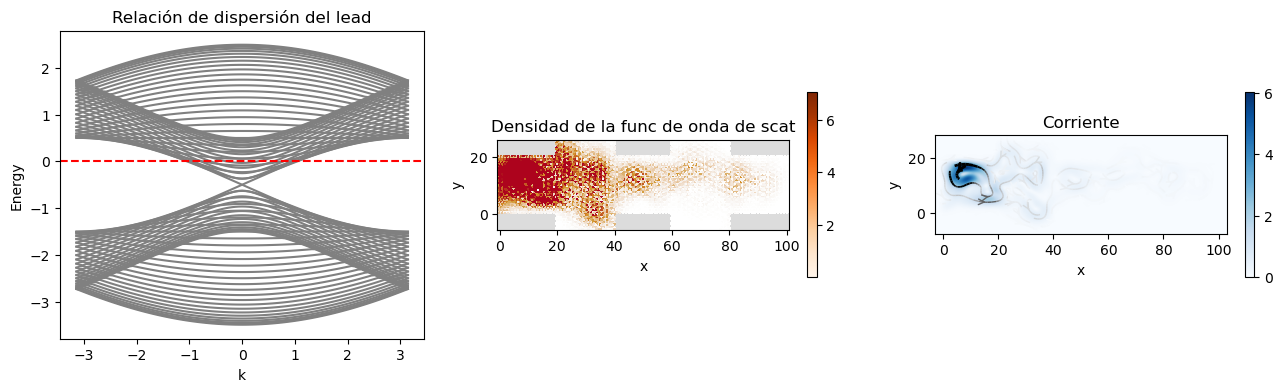

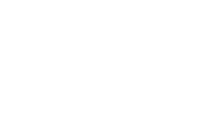

In [55]:
p = dict(t=1.0, mu=0.5, mu_lead=0.5, Edis = 1, prob = 0.02, B = 0.17)
fig1 = obtain_wf(syst, energy=0, params = p);


##  <span style="color:orange">Ejercicio 4  </span>
Es verdaderamente importante incluir el matching de las fases entre los leads y la zona de scattering?
Modifica el código para eliminar fase constante en los leads 4 y 5. Se ve mucha diferencia con el caso con la fase continua?